<a href="https://www.kaggle.com/code/vikkach/nlp-with-disaster-tweets-bidirectional-lstm-gru?scriptVersionId=234332925" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm import tqdm
from string import punctuation
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [3]:
class Config():
    train_data_path = '/kaggle/input/nlp-getting-started/train.csv'
    test_data_path = '/kaggle/input/nlp-getting-started/test.csv'
    num_words = 10000
    n_epochs = 50
    batch_size = 32
    max_len = 10000

<div style="background-color: #2C3E50; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Disaster Tweets
</div>

<div style="background-color: #ECF0F1; color: #2C3E50; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Problem Statement
</div>

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

The goal is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

## Dataset

**10,000 tweets**

* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - a sample submission file in the correct format

|**Feature**|**Description**|
|-----|-----|
|**id** | a unique identifier for each tweet|
|**text** | the text of the tweet|
|**location** | the location the tweet was sent from (may be blank)|
|**keyword** | a particular keyword from the tweet (may be blank)|
|**target** | in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)|

<div style="background-color: #ECF0F1; color: #2C3E50; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    EDA
</div>

In [4]:
train_df = pd.read_csv(Config.train_data_path)
test_df = pd.read_csv(Config.test_data_path)

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Check null values:

In [7]:
train_df.shape

(7613, 5)

We will make a basic data cleaning before EDA

In [8]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

keyword and location features have missing values. Let's fill them with "unknown" value

In [9]:
train_df['keyword'].fillna('unknown', inplace=True)
train_df['location'].fillna('unknown', inplace=True)

<ipython-input-9-14a49b21eabb>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['keyword'].fillna('unknown', inplace=True)
<ipython-input-9-14a49b21eabb>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [10]:
# check null values again
train_df.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [11]:
# Lower case for consistency
train_df['text_clean'] = train_df['text'].str.lower()

In [12]:
# Remove punctuation, URLs, etc.
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # remove punctuation
    return text

train_df['text_clean'] = train_df['text_clean'].apply(clean_text)

Check target distribution:

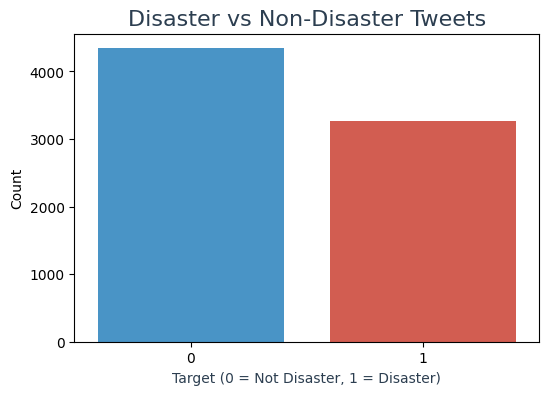

In [13]:
custom_palette = ["#3498DB", "#E74C3C"]
sns.set_palette(custom_palette)

plt.figure(figsize=(6,4))
sns.countplot(x='target', data=train_df)
plt.title('Disaster vs Non-Disaster Tweets', color='#2C3E50', fontsize=16)
plt.xlabel('Target (0 = Not Disaster, 1 = Disaster)', color='#2C3E50')
plt.ylabel('Count')
plt.show()

Tweet length by class:

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


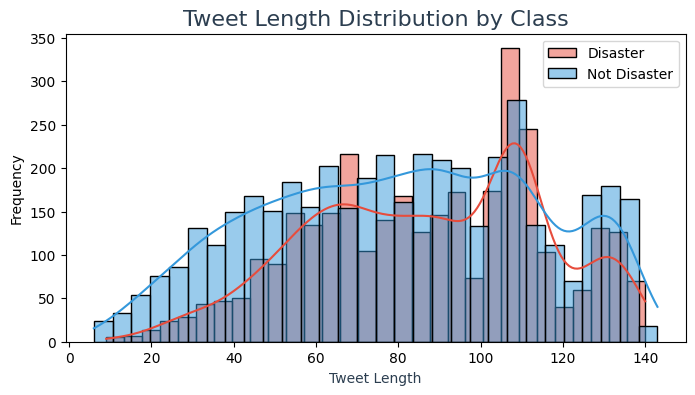

In [14]:
train_df['text_len'] = train_df['text_clean'].apply(len)

plt.figure(figsize=(8,4))
sns.histplot(train_df[train_df['target']==1]['text_len'], bins=30, color="#E74C3C", label='Disaster', kde=True)
sns.histplot(train_df[train_df['target']==0]['text_len'], bins=30, color="#3498DB", label='Not Disaster', kde=True)
plt.title("Tweet Length Distribution by Class", color="#2C3E50", fontsize=16)
plt.xlabel("Tweet Length", color="#2C3E50")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Most common keywords:

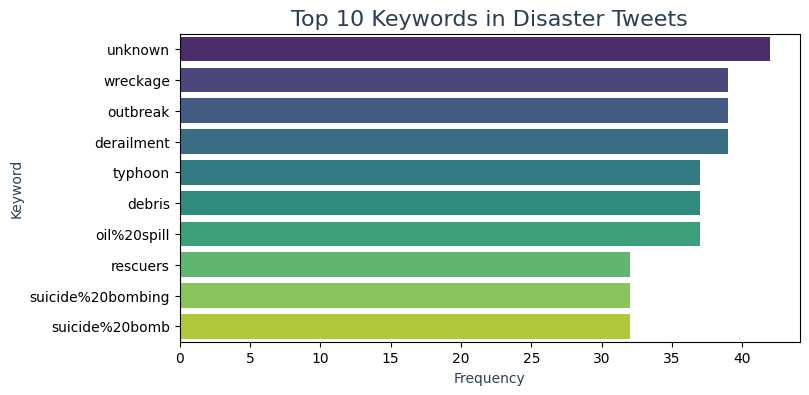

In [15]:
top_keywords = train_df[train_df['target']==1]['keyword'].value_counts().nlargest(10)

plt.figure(figsize=(8,4))
sns.barplot(x=top_keywords.values, y=top_keywords.index, palette="viridis")
plt.title("Top 10 Keywords in Disaster Tweets", color="#2C3E50", fontsize=16)
plt.xlabel("Frequency", color="#2C3E50")
plt.ylabel("Keyword", color="#2C3E50")
plt.show()

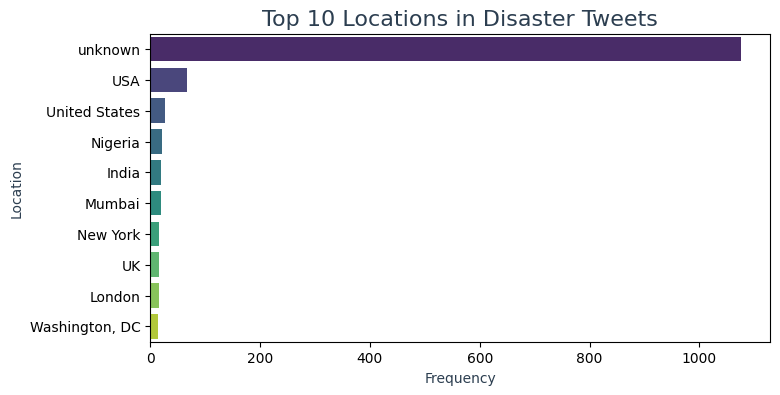

In [16]:
top_keywords = train_df[train_df['target']==1]['location'].value_counts().nlargest(10)

plt.figure(figsize=(8,4))
sns.barplot(x=top_keywords.values, y=top_keywords.index, palette="viridis")
plt.title("Top 10 Locations in Disaster Tweets", color="#2C3E50", fontsize=16)
plt.xlabel("Frequency", color="#2C3E50")
plt.ylabel("Location", color="#2C3E50")
plt.show()

## Analysis Result

* Target value is balanced
* Text cleaning is super important
* Keywords should be encoded
* Location feature has a lot of unknown values, will be removed

<div style="background-color: #ECF0F1; color: #2C3E50; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Data Preprocessing
</div>

Before text data is transformed into numerical features the text string data can be
preprocessed. These steps include:
* **Words lowercase**
  
  Converting all text to lowercase ensures uniformity. For example, "Tech" and "tech" are the same word. This reduces redundancy.
  
* **Remove punctuation and additional empty strings**

  Punctuation typically does not have meaningful information. Eliminating empty strings removes unnecessary noise.

* **Stemming**

  Stemming reduces words to their base or root form (e.g., "running" → "run"). This minimizes redundancy, reduces the feature space and aids generalization.

* **Stop word removal**

  Removing stop words reduces the noise and allows the model to focus on more important words that convey the actual meaning of the text.

In [17]:
def pre_process(df):
    reviews = []
    stopwords_set = set(stopwords.words("english"))
    ps = PorterStemmer()
    for p in tqdm(df["text"]):
        # convert to lowercase 
        p = p.lower()
        
        # remove punctuation and additional empty strings
        p = ''.join([c for c in p if c not in punctuation])
        reviews_split = p.split()
        reviews_wo_stopwords = [word for word in reviews_split if not word in stopwords_set]
        reviews_stemm = [ps.stem(w) for w in reviews_wo_stopwords]
        p = ' '.join(reviews_stemm)
        reviews.append(p)
    return reviews

train_df['text_pp'] = pre_process(train_df)
test_df['text_pp'] = pre_process(test_df)

100%|██████████| 3263/3263 [00:00<00:00, 4805.35it/s]


In [18]:
# compare the same phrase before and after pre-processing
print('Phrase before pre-processing: ', train_df['text'][0])
print('Phrase after pre-processing: ', train_df['text_pp'][0])

Phrase before pre-processing:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Phrase after pre-processing:  deed reason earthquak may allah forgiv us


In [19]:
X = train_df["text_pp"]
y = train_df["target"]

X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test_raw = test_df["text_pp"]

<div style="background-color: #ECF0F1; color: #2C3E50; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Word Embedding
</div>

In [20]:
tokenizer = Tokenizer(num_words=Config.num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_raw)
X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_val_seq = tokenizer.texts_to_sequences(X_val_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

# Dynamically choose max_len (90th percentile of lengths)
sequence_lengths = [len(seq) for seq in X_train_seq]
Config.max_len = int(np.percentile(sequence_lengths, 90))

X_train_pad = pad_sequences(X_train_seq, maxlen=Config.max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=Config.max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=Config.max_len, padding='post')

<div style="background-color: #ECF0F1; color: #2C3E50; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Model
</div>

Different architectures have varying strengths and weaknesses. We will compare architectures like LSTM and GRU to identify the best-suited architecture for my task.

We gonna use such performance improvement techniques:

* Early Stopping: Stop training when validation performance plateaus to prevent overfitting.

* Dropout: Randomly ignore neurons during training to reduce overfitting.

* Regularization (L1): Add penalty terms to the loss function to discourage large weights and prevent overfitting.

* Learning Rate Scheduling: Adjust the learning rate during training to improve convergence and performance.

<div style="background-color: #ECF0F1; color: #2C3E50; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Bidirectional LSTM
</div>

In [21]:
model_lstm = Sequential([
    Embedding(input_dim=Config.num_words, output_dim=64, input_length=Config.max_len),
    Bidirectional(LSTM(64, 
                       return_sequences=False, 
                       dropout=0.2,
                       recurrent_dropout=0.2)),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5, 
                           restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            factor=0.5, 
                                            patience=5, 
                                            min_lr=1e-5)

In [23]:
model_lstm.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history_lstm = model_lstm.fit(X_train_pad, 
              y_train, 
              epochs=Config.n_epochs, 
              batch_size=Config.batch_size,
              validation_data=(X_val_pad, y_val), 
              callbacks=[early_stop, learning_rate_reduction])


Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.6077 - loss: 0.6450 - val_accuracy: 0.7781 - val_loss: 0.4833 - learning_rate: 0.0010
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8213 - loss: 0.4085 - val_accuracy: 0.7905 - val_loss: 0.4756 - learning_rate: 0.0010
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8630 - loss: 0.3398 - val_accuracy: 0.8076 - val_loss: 0.4548 - learning_rate: 0.0010
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8865 - loss: 0.2915 - val_accuracy: 0.7958 - val_loss: 0.4530 - learning_rate: 0.0010
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9024 - loss: 0.2536 - val_accuracy: 0.7925 - val_loss: 0.4978 - learning_rate: 0.0010
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9040 - loss: 0.2449 - val_accuracy: 0.7866 - val_loss: 0.5050 - learning_rate: 0.0010
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9179 - loss: 0.

### Evaluation

In [24]:
def plot_evaluation(history):

    plt.figure(figsize=(18, 5))
    
    # accuracy
    plt.subplot(1, 2, 1)
    
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='#1f77b4', linestyle="dashed")
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='#1f77b4')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    
    # loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='#1f77b4', linestyle="dashed")
    plt.plot(history.history['val_loss'], label='Val Loss', color='#1f77b4')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    
    plt.show()

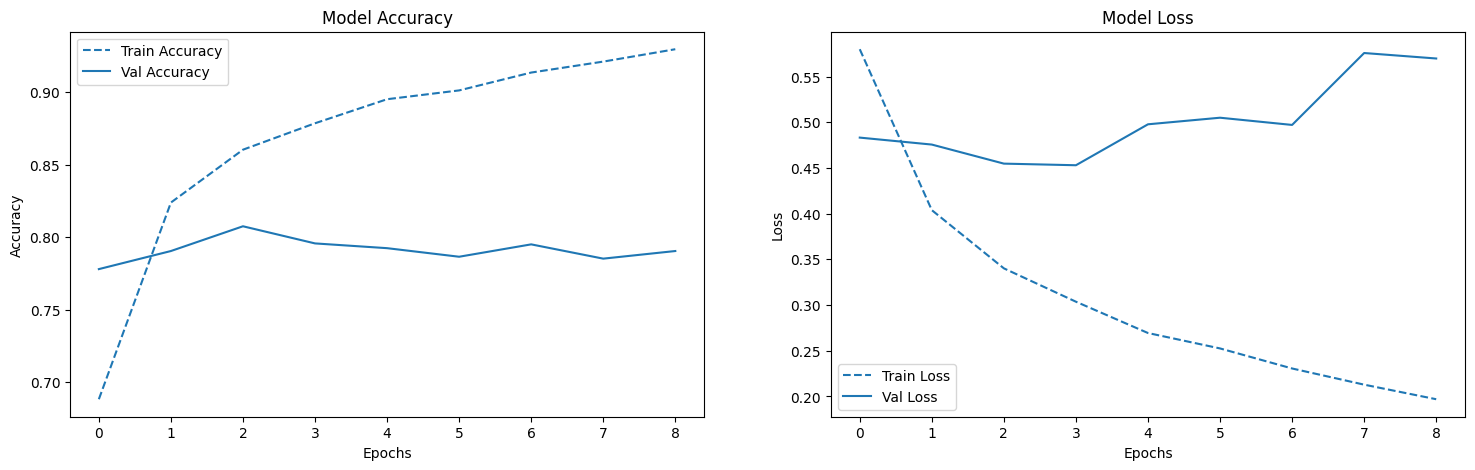

In [25]:
plot_evaluation(history_lstm)

Bidirectional LSTM model is overfitting:

* The training accuracy improves rapidly while
* Validation accuracy peaks early and declines
* Validation loss increases after a few epochs

Let's check test results:

In [26]:
predictions_lstm = (model_lstm.predict(X_test_pad) > 0.5).astype(int).flatten()
submission_lstm = pd.DataFrame({
    'id': test_df['id'],
    'target': predictions_lstm
})
submission_lstm.to_csv('submission_lstm.csv', index=False)
submission_lstm.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


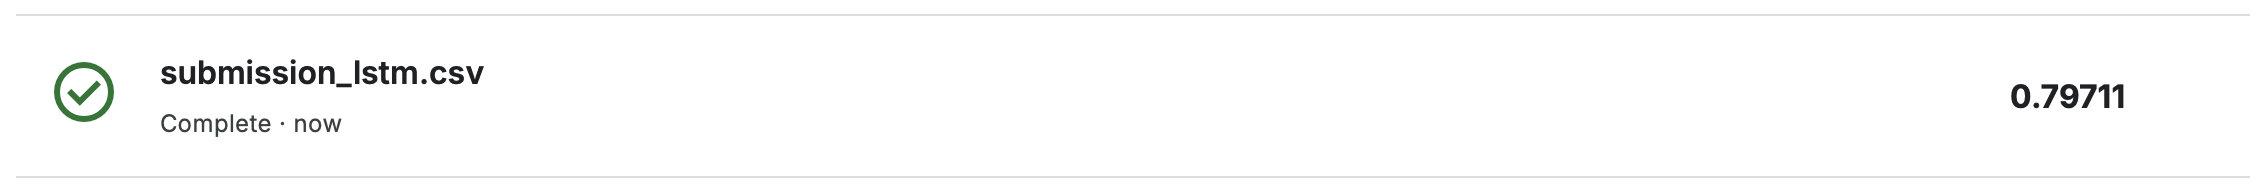

<div style="background-color: #ECF0F1; color: #2C3E50; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Bidirectional 2xGRU
</div>

In [27]:
model_gru = Sequential([
    Embedding(input_dim=Config.num_words, output_dim=64, input_length=Config.max_len),
    Bidirectional(GRU(32, 
                       return_sequences=True, 
                       kernel_regularizer=l2(0.01))),
    Bidirectional(GRU(64, 
                       kernel_regularizer=l2(0.01))),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
model_gru.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history_gru = model_gru.fit(X_train_pad, 
              y_train, 
              epochs=Config.n_epochs, 
              batch_size=Config.batch_size,
              validation_data=(X_val_pad, y_val), 
              callbacks=[early_stop, learning_rate_reduction])

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5762 - loss: 2.2454 - val_accuracy: 0.5975 - val_loss: 0.6880 - learning_rate: 0.0010
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6264 - loss: 0.6511 - val_accuracy: 0.8037 - val_loss: 0.4736 - learning_rate: 0.0010
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8208 - loss: 0.4271 - val_accuracy: 0.8043 - val_loss: 0.4604 - learning_rate: 0.0010
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8555 - loss: 0.3662 - val_accuracy: 0.7997 - val_loss: 0.5130 - learning_rate: 0.0010
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8762 - loss: 0.3192 - val_accuracy: 0.7984 - val_loss: 0.4862 - learning_rate: 0.0010


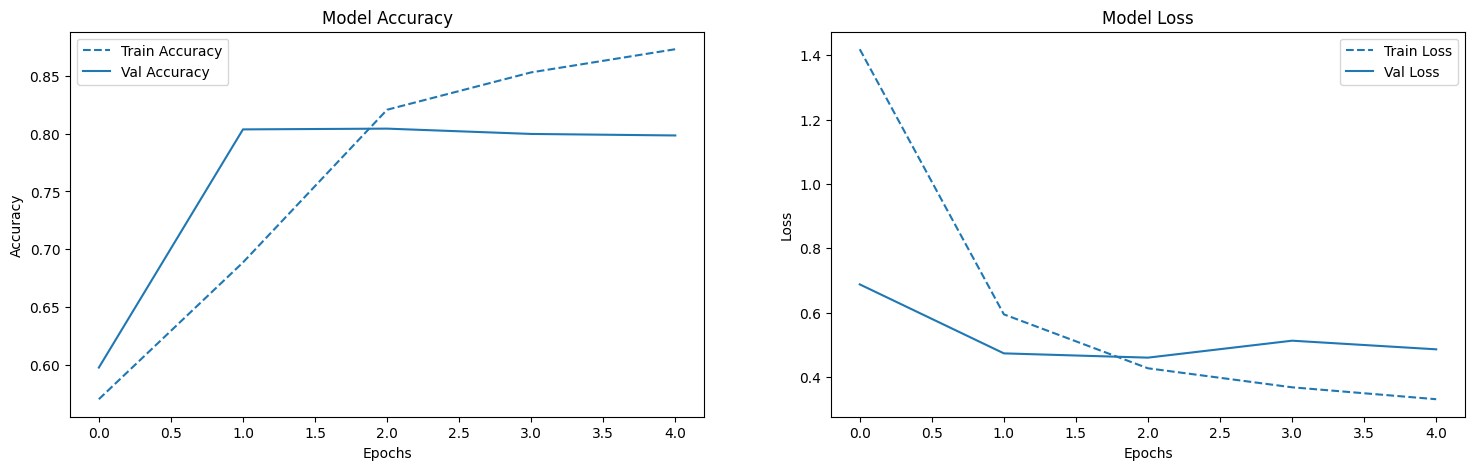

In [29]:
plot_evaluation(history_gru)

* Model learns quickly and reaches over 80% validation accuracy by epoch 3–4.
* Validation accuracy is competitive with LSTM model.
* No extreme overfitting in the first few epochs.

But
* Validation loss starts rising in epoch 5 while accuracy slightly drops → beginning of overfitting.
* Training accuracy keeps improving → classic sign of overfitting starting.
* Model might be too large or learning too quickly.

Let's check test results:

In [30]:
predictions_gru = model_gru.predict(X_test_pad).round().astype(int).reshape(3263) 
submission_gru = pd.DataFrame({
    'id': test_df['id'],
    'target': predictions_gru
})
submission_gru.to_csv('submission_gru.csv', index=False)
submission_gru.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


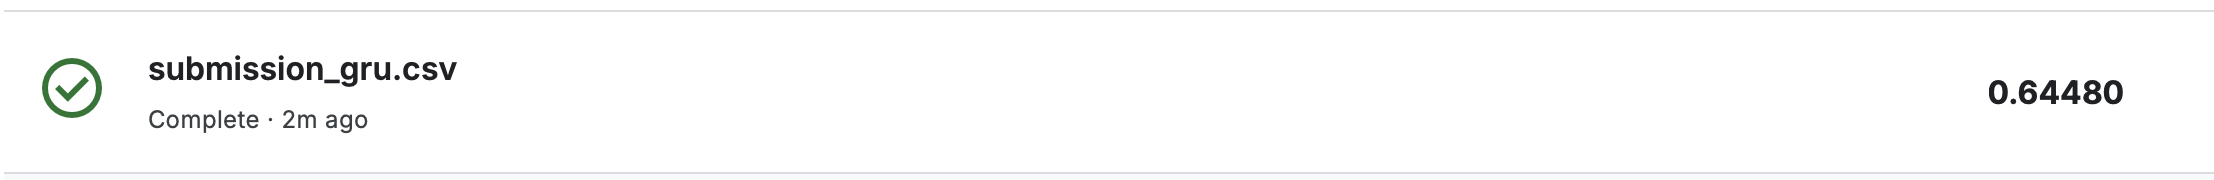

<div style="background-color: #ECF0F1; color: #2C3E50; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Conclusion
</div>

* Bidirectional LSTM outperformed Bidirectional GRU with a test accuracy of 0.797 vs 0.644.
* While GRUs are generally faster, in this case, LSTM showed better generalization on validation and test sets.
* For future work, exploring transformer-based models like BERT could further improve performance.